In [24]:
import pandas as pd
import numpy as np
import json

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geohash2
import pyproj
from pyproj import Proj, transform, CRS
from functools import partial
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
from scipy.spatial import cKDTree
from scipy.stats import poisson

import random
import pickle
from tqdm import tqdm
from time import sleep

In [63]:
geo_gdf = gpd.read_file('./Wuerzburg_Data/geo_wuerzburg.gpkg')

bevölkerungs_gdf = gpd.read_file('./Wuerzburg_Data/pharmacy_assigned_complete.gpkg')
bevölkerungs_gdf['Alter'] = bevölkerungs_gdf['Alter'].apply(json.loads)
bevölkerungs_gdf['Geschlecht'] = bevölkerungs_gdf['Geschlecht'].apply(json.loads)

customers_gdf = gpd.read_file('./Wuerzburg_Data/cluster_wuerzburg.gpkg')
customers_gdf['Alter'] = customers_gdf['Alter'].apply(json.loads)

warehouses_gdf = gpd.read_file('./Wuerzburg_Data/warehouses_wuerzburg.gpkg')

pharmacy_df = pd.read_csv('./Wuerzburg_Data/wuerzburg-Apotheken.csv')
pharmacy_gdf = gpd.GeoDataFrame(pharmacy_df, geometry=gpd.points_from_xy(pharmacy_df['lon'], pharmacy_df['lat']), crs=CRS("EPSG:4326"))
pharmacy_gdf = pharmacy_gdf.to_crs(bevölkerungs_gdf.crs)

In [64]:
# Funktion zum Berechnen des Durchschnittsalters
def calculate_average_age(age_dict):
    age_ranges = list(age_dict.keys())
    age_counts = list(age_dict.values())
    age_midpoints = [np.mean(list(map(int, age_range.split('-')))) if '-' in age_range else 80 for age_range in age_ranges]
    weighted_sum = sum(midpoint * count for midpoint, count in zip(age_midpoints, age_counts))
    total_count = sum(age_counts)
    average_age = weighted_sum / total_count if total_count != 0 else 0
    return average_age

In [65]:
bevölkerungs_gdf['average_age'] = bevölkerungs_gdf['Alter'].apply(calculate_average_age)
customers_gdf['average_age'] = customers_gdf['Alter'].apply(calculate_average_age)

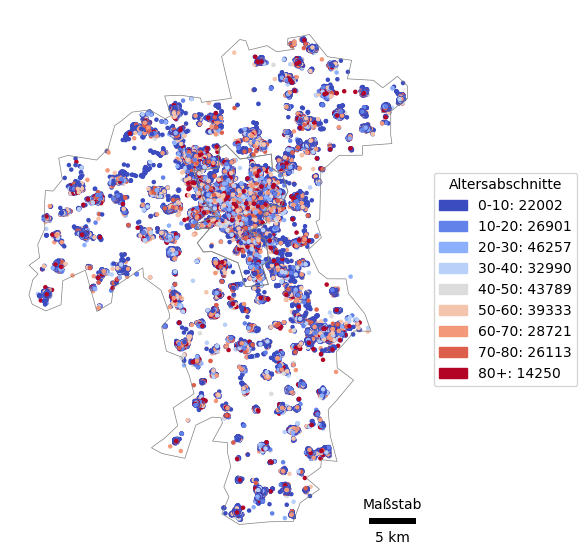

In [66]:
# Berechne die Gesamtanzahl je Altersgruppe
total_counts = {age_range: 0 for age_range in age_ranges}
for age_dict in customers_gdf['Alter']:
    for age_range, count in age_dict.items():
        total_counts[age_range] += int(count)

# Erstelle eine benutzerdefinierte Farbkarte
age_ranges = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80+"]
colors = plt.cm.coolwarm(np.linspace(0, 1, len(age_ranges)))
cmap = ListedColormap(colors)

# Zuordnung der Farben zu Altersabschnitten
age_color_map = {age_range: color for age_range, color in zip(age_ranges, colors)}

# Plot
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the raster with boundary
geo_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plot the customers with custom colormap based on average age
bevölkerungs_gdf.plot(ax=ax, column='average_age', cmap=cmap, markersize = 5)

# Add title and labels
plt.axis('off')

# Add custom legend for age ranges with total counts
handles = [Patch(color=age_color_map[age_range], label=f"{age_range}: {total_counts[age_range]}") for age_range in age_ranges]
ax.legend(handles=handles, title="Altersabschnitte", loc='center left', bbox_to_anchor=(1, 0.5))

# Add scale bar
scalebar = ScaleBar(1, location='lower right', label='Maßstab')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.show()

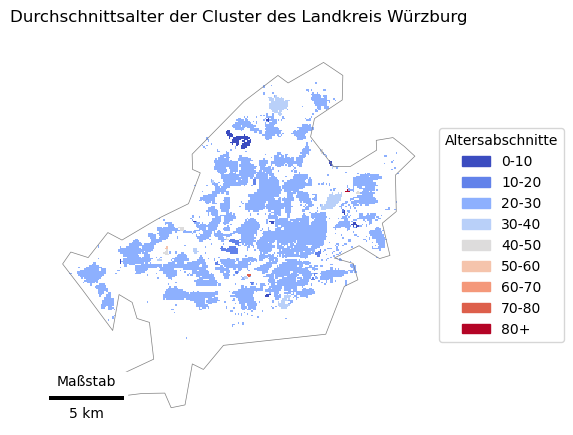

In [36]:
# Erstelle eine benutzerdefinierte Farbkarte
age_ranges = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80+"]
colors = plt.cm.coolwarm(np.linspace(0, 1, len(age_ranges)))
cmap = ListedColormap(colors)

# Zuordnung der Farben zu Altersabschnitten
age_color_map = {age_range: color for age_range, color in zip(age_ranges, colors)}

# Plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the raster with boundary
geo_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plot the customers with custom colormap based on average age
customers_gdf.plot(ax=ax, column='average_age', cmap=cmap, markersize= 40)

# Add title and labels
plt.axis('off')
plt.title('Durchschnittsalter der Cluster des Landkreis Würzburg')

# Add custom legend for age ranges
handles = [Patch(color=age_color_map[age_range], label=age_range) for age_range in age_ranges]
ax.legend(handles=handles, title="Altersabschnitte", loc='center left', bbox_to_anchor=(1, 0.5))

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.show()

# Plotting the Data

In [ ]:
# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
pharmacy_gdf.plot(ax=ax, markersize=20)

# Titel hinzufügen
plt.title('Apothekenstandorte im Landkreis Würzburg')
plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

In [ ]:
# Create a colormap based on the "nachfrage" column
vmin = customers_gdf['nachfrage'].min()
vmax = customers_gdf['nachfrage'].max()
cmap = 'coolwarm'  

# Plot the raster with boundary
ax = geo_gdf.boundary.plot(color='gray', linewidth=0.5, figsize = (5,5))

# Plot the customers with custom colormap
customers_gdf.plot(ax=ax, column='nachfrage', cmap=cmap, vmin=vmin, vmax=vmax)

# Add title and labels
plt.axis('off')
plt.title('Nachfrage der Cluster des Landkreis Würzburg')
#plt.xlabel('Breitengradkoordinate im CSR3035 Format')
#plt.ylabel('Längengradkoordinate im CSR3035 Format')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Nachfrage')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')  # 1 pixel = 1 meter
ax.add_artist(scalebar)

plt.show()

In [ ]:
# Create a colormap based on the "total_price" column
vmin = warehouses_gdf['total_price_big'].min()
vmax = warehouses_gdf['total_price_big'].max()
cmap = 'coolwarm'  


# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='total_price_big', cmap=cmap, markersize=20)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien (Max) des Landkreis Würzburg')
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Gesamter Mietpreis für ein Jahr')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

In [ ]:
# Create a colormap based on the "total_price" column
vmin = warehouses_gdf['total_price_small'].min()
vmax = warehouses_gdf['total_price_small'].max()
cmap = 'coolwarm'  


# Rahmen der Grafik definieren
fig, ax = plt.subplots(figsize=(6, 6))
geo_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf.plot(ax=ax, column='total_price_small', cmap=cmap, markersize=20)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien (Min) des Landkreis Würzburg')
plt.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label='Gesamter Mietpreis für ein Jahr')  # Adjust shrink value as needed

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Zeige den Plot an
plt.show()

# Lösungsvisualisierungen

In [ ]:
#Rahmen der Grafik definieren
ax = geo_gdf.boundary.plot(color='gray', linewidth=0.5, figsize = (7,7))

# Plotte gdf_loaded auf dieselbe Achse
warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].plot(ax=ax, color='red', marker='o', markersize=25)
warehouses_gdf.loc[opened_warehouses].plot(ax=ax, color='blue', marker='^', markersize=35)

# Titel hinzufügen
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')

plt.axis('off')

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Add legend
custom_legend = [Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='Geöffnet'),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Nicht geöffnet')]
plt.legend(handles=custom_legend, title='Warenhäuser', bbox_to_anchor=(1,0.95), loc='upper left', borderaxespad=0., fontsize='small', ncol=1)
plt.tight_layout()

# # Index jedes Warehouses anzeigen
# for idx, row in warehouses_gdf.loc[opened_warehouses].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')

# for idx, row in warehouses_gdf[~warehouses_gdf.index.isin(opened_warehouses)].iterrows():
#     plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')

# Zeige den Plot an
plt.show()

In [ ]:
# Create a colormap with a color for each opened warehouse
colors = plt.cm.tab20(np.linspace(0, 1, len(opened_warehouses)))
warehouse_colors = dict(zip(opened_warehouses, colors))

# Create a dictionary to map each warehouse to a color
warehouse_colors = {
    warehouse: color
    for warehouse, color in zip(opened_warehouses, warehouse_colors.values())
}

# Plot the boundaries of the region
ax = geo_gdf.boundary.plot(color='gray', linewidth=0.5, figsize=(8, 8))


# Plot the customers with the color of their assigned warehouse
for index, row in customers_gdf.iterrows():
    warehouse = row['assigned_warehouse']
    color = warehouse_colors.get(warehouse, 'gray')  # Use gray color if warehouse is not in the dictionary
    customers_gdf.iloc[[index]].plot(ax=ax, color=color, markersize=20)


# Plot the warehouses with their assigned colors
for warehouse, color in warehouse_colors.items():
    warehouses_gdf[warehouses_gdf.index == warehouse].plot(ax=ax, color=color, marker='^', markersize=50, edgecolor='black')


# Turn off axis
plt.axis('off')

# Add title
plt.title('Lagerhaltungsimmobilien des Landkreis Würzburg')

# Add legend
legend_handles = [Line2D([0], [0], marker='^', color='w', markerfacecolor=color, markersize=10, label=warehouse) for warehouse, color in warehouse_colors.items()]
ax.legend(handles=legend_handles, title='Warenhäuser', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=2)

# Add scale bar
scalebar = ScaleBar(1, location='lower left', label='Maßstab')
ax.add_artist(scalebar)

# Show the plot
plt.show()